Having done [crypto volatility intro analysis](https://colab.research.google.com/drive/1kPI3xucp_IrnGK7_cXFbCfZCn3H8pIsT?usp=sharing) and initially looked into doing research into Volatility Risk Premium, I found that data to be harder to obtain as there's no ready made VIX3M or VVIX. To keep moving and inspired by losing money it seems volatility doesn't exist in isolation and it's notably in relationship with underlying movement and volume. Underlying price and volume is available via API so I pulled that to get to work for the next round of research.

Also do note that in this research series when I say Volatility it's meant for priced Implied Volatility not Realized Volatility or Historical Volatility.

In [ ]:
install.packages('tidyverse')
install.packages('lubridate')
install.packages('slider')
install.packages('tibbletime')
library(tidyverse)
library(lubridate)
library(slider)
library(tibbletime)


# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘warp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘zoo’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: timechange


Attaching package: ‘lubridate’


The following 

Load Dvol and prepare data into what we need

In [ ]:
btc_vol <- read.csv(file = '/content/btc_dvol.csv')

btc_vol <- btc_vol %>% 
  mutate(datetime = ymd_hms(datetime),
          ticker = 'btc')

btc_vol %>% head()

,timestamp,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,1.616544e+12,84.80,85.41,84.67,84.88,2021-03-24 00:00:00,btc
2,1.616548e+12,84.88,88.07,84.77,86.60,2021-03-24 01:00:00,btc
3,1.616551e+12,86.60,87.10,86.19,86.19,2021-03-24 02:00:00,btc
4,1.616555e+12,86.19,86.95,86.09,86.31,2021-03-24 03:00:00,btc
5,1.616558e+12,86.31,86.79,84.31,84.35,2021-03-24 04:00:00,btc
6,1.616562e+12,84.35,84.99,83.51,83.54,2021-03-24 05:00:00,btc


In [ ]:
btc <- read.csv(file = '/content/btc.csv')

btc <- btc %>% 
  mutate(datetime = ymd_hms(datetime),
          ticker = 'btc')

btc %>% head()

,volume,ticks,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,698.6488,1.604164e+12,13835.5,13835.5,13753.5,13796.5,2020-10-31 17:00:00,btc
2,669.8038,1.604167e+12,13796.5,13796.5,13721.5,13736.0,2020-10-31 18:00:00,btc
3,646.3820,1.604171e+12,13735.0,13833.0,13702.0,13801.0,2020-10-31 19:00:00,btc
4,444.1821,1.604174e+12,13800.5,13854.0,13768.5,13853.5,2020-10-31 20:00:00,btc
5,233.3344,1.604178e+12,13853.5,13866.0,13832.5,13861.5,2020-10-31 21:00:00,btc
6,338.4205,1.604182e+12,13861.5,13910.5,13841.5,13892.0,2020-10-31 22:00:00,btc


In [ ]:
btc_v <- btc_vol %>%
  select(datetime, close, ticker) %>%
    rename('dvol' = 'close')

btc_v %>% head()

,datetime,dvol,ticker
,<dttm>,<dbl>,<chr>
1,2021-03-24 00:00:00,84.88,btc
2,2021-03-24 01:00:00,86.60,btc
3,2021-03-24 02:00:00,86.19,btc
4,2021-03-24 03:00:00,86.31,btc
5,2021-03-24 04:00:00,84.35,btc
6,2021-03-24 05:00:00,83.54,btc


In [ ]:
btc_combined <- left_join(btc, btc_v, 
              by = c('datetime' = 'datetime', 'ticker' = 'ticker')) %>%
                na.omit()

btc_combined %>% head()

,volume,ticks,open,high,low,close,datetime,ticker,dvol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<dbl>
3441,1010.2037,1.616544e+12,54398.5,54731.5,53646.0,53770.5,2021-03-24 00:00:00,btc,84.88
3442,423.6771,1.616548e+12,53764.5,54605.0,53593.0,54530.0,2021-03-24 01:00:00,btc,86.60
3443,248.3579,1.616551e+12,54517.0,54684.5,54405.5,54483.0,2021-03-24 02:00:00,btc,86.19
3444,398.0028,1.616555e+12,54482.5,54787.5,54101.5,54402.0,2021-03-24 03:00:00,btc,86.31
3445,557.3089,1.616558e+12,54390.5,54610.0,54023.5,54156.5,2021-03-24 04:00:00,btc,84.35
3446,771.9600,1.616562e+12,54157.0,54339.0,53813.0,54183.5,2021-03-24 05:00:00,btc,83.54


In [ ]:
eth_vol <- read.csv(file = '/content/eth_dvol.csv')

eth_vol <- eth_vol %>% 
  mutate(datetime = ymd_hms(datetime),
          ticker = 'eth')

eth_vol %>% head()

,timestamp,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,1.616544e+12,94.18,94.30,93.68,93.86,2021-03-24 00:00:00,eth
2,1.616548e+12,93.86,94.65,93.77,94.35,2021-03-24 01:00:00,eth
3,1.616551e+12,94.35,97.26,94.25,94.65,2021-03-24 02:00:00,eth
4,1.616555e+12,94.65,95.07,94.54,95.07,2021-03-24 03:00:00,eth
5,1.616558e+12,95.07,95.07,94.16,94.18,2021-03-24 04:00:00,eth
6,1.616562e+12,94.18,94.38,93.39,93.41,2021-03-24 05:00:00,eth


In [ ]:
eth <- read.csv(file = '/content/eth.csv')

eth <- eth %>% 
  mutate(datetime = ymd_hms(datetime),
          ticker = 'eth')

eth %>% head()

,volume,ticks,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,4766.528,1.604164e+12,388.85,388.9,386.30,387.20,2020-10-31 17:00:00,eth
2,4578.452,1.604167e+12,387.20,387.2,384.30,385.35,2020-10-31 18:00:00,eth
3,3665.095,1.604171e+12,385.35,387.4,385.05,385.85,2020-10-31 19:00:00,eth
4,2459.088,1.604174e+12,385.85,388.2,385.35,388.15,2020-10-31 20:00:00,eth
5,1601.164,1.604178e+12,388.20,388.2,387.25,387.50,2020-10-31 21:00:00,eth
6,2789.143,1.604182e+12,387.55,388.9,387.25,388.75,2020-10-31 22:00:00,eth


In [ ]:
eth_v <- eth_vol %>%
  select(datetime, close, ticker) %>%
    rename('dvol' = 'close')

eth_v %>% head()

,datetime,dvol,ticker
,<dttm>,<dbl>,<chr>
1,2021-03-24 00:00:00,93.86,eth
2,2021-03-24 01:00:00,94.35,eth
3,2021-03-24 02:00:00,94.65,eth
4,2021-03-24 03:00:00,95.07,eth
5,2021-03-24 04:00:00,94.18,eth
6,2021-03-24 05:00:00,93.41,eth


In [ ]:
eth_combined <- left_join(eth, eth_v, 
              by = c('datetime' = 'datetime', 'ticker' = 'ticker')) %>%
                na.omit()

eth_combined %>% head()

,volume,ticks,open,high,low,close,datetime,ticker,dvol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<dbl>
3441,3712.749,1.616544e+12,1668.75,1681.20,1648.35,1654.80,2021-03-24 00:00:00,eth,93.86
3442,1800.298,1.616548e+12,1654.80,1678.90,1652.05,1675.15,2021-03-24 01:00:00,eth,94.35
3443,1399.688,1.616551e+12,1675.10,1683.15,1671.00,1679.05,2021-03-24 02:00:00,eth,94.65
3444,2053.328,1.616555e+12,1679.05,1687.00,1673.65,1679.45,2021-03-24 03:00:00,eth,95.07
3445,3552.893,1.616558e+12,1679.35,1689.20,1675.50,1678.15,2021-03-24 04:00:00,eth,94.18
3446,2139.306,1.616562e+12,1678.20,1683.85,1669.20,1673.50,2021-03-24 05:00:00,eth,93.41


In [ ]:
vol <- btc_combined %>%
  bind_rows(eth_combined) %>%
    arrange(datetime)

vol %>% 
    head()

,volume,ticks,open,high,low,close,datetime,ticker,dvol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<dbl>
1,1010.2037,1.616544e+12,54398.50,54731.50,53646.00,53770.50,2021-03-24 00:00:00,btc,84.88
2,3712.7485,1.616544e+12,1668.75,1681.20,1648.35,1654.80,2021-03-24 00:00:00,eth,93.86
3,423.6771,1.616548e+12,53764.50,54605.00,53593.00,54530.00,2021-03-24 01:00:00,btc,86.60
4,1800.2983,1.616548e+12,1654.80,1678.90,1652.05,1675.15,2021-03-24 01:00:00,eth,94.35
5,248.3579,1.616551e+12,54517.00,54684.50,54405.50,54483.00,2021-03-24 02:00:00,btc,86.19
6,1399.6885,1.616551e+12,1675.10,1683.15,1671.00,1679.05,2021-03-24 02:00:00,eth,94.65


Start by plotting. So not only is Dvol a stationary looking data. Volume is looking even more stationary.

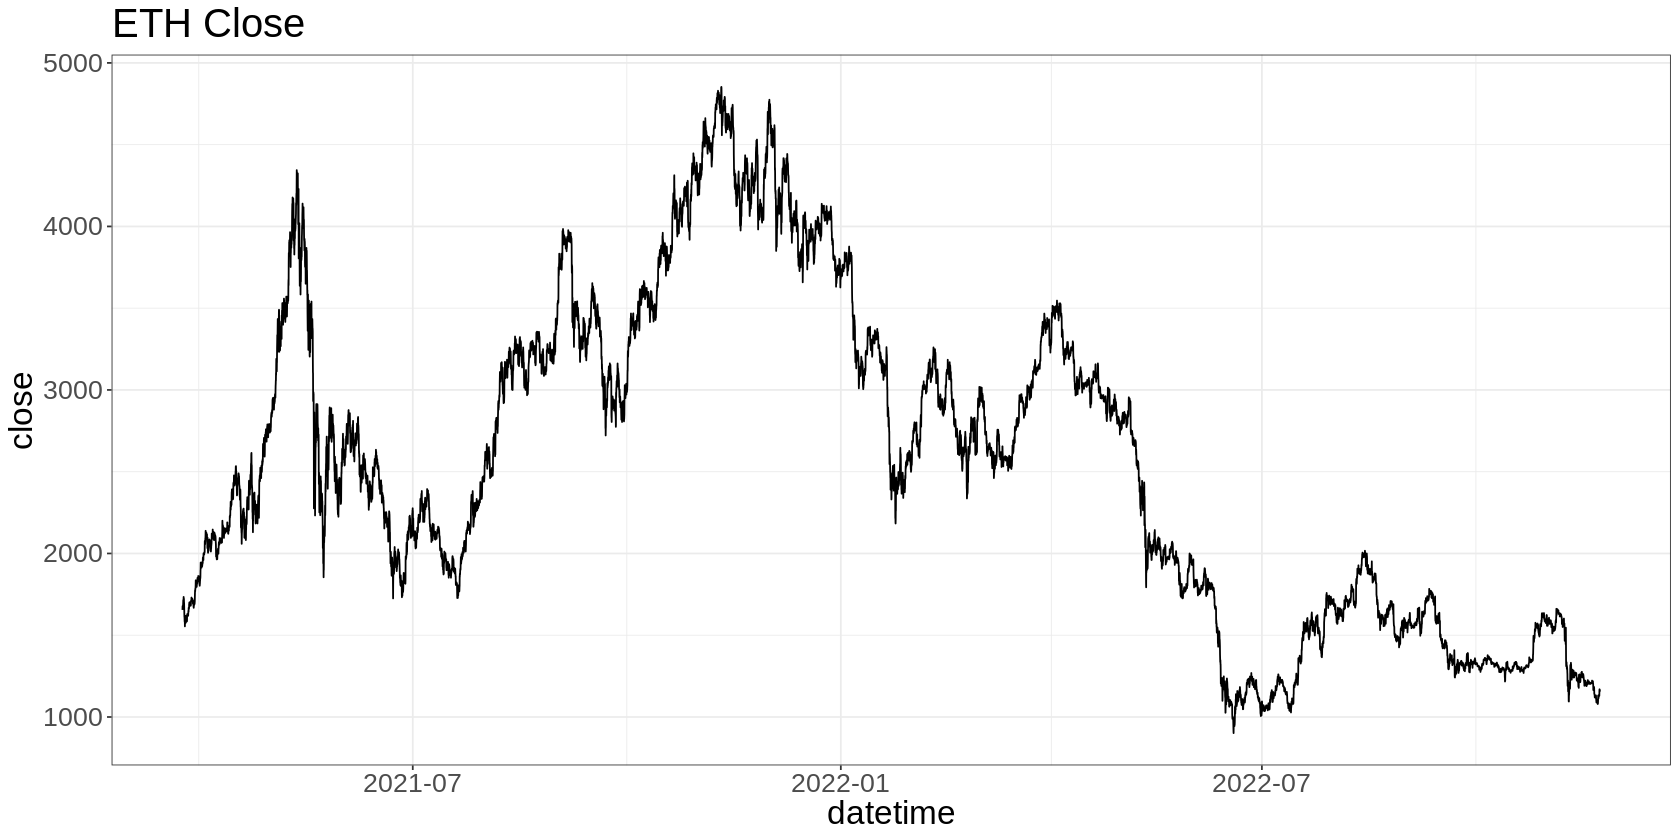

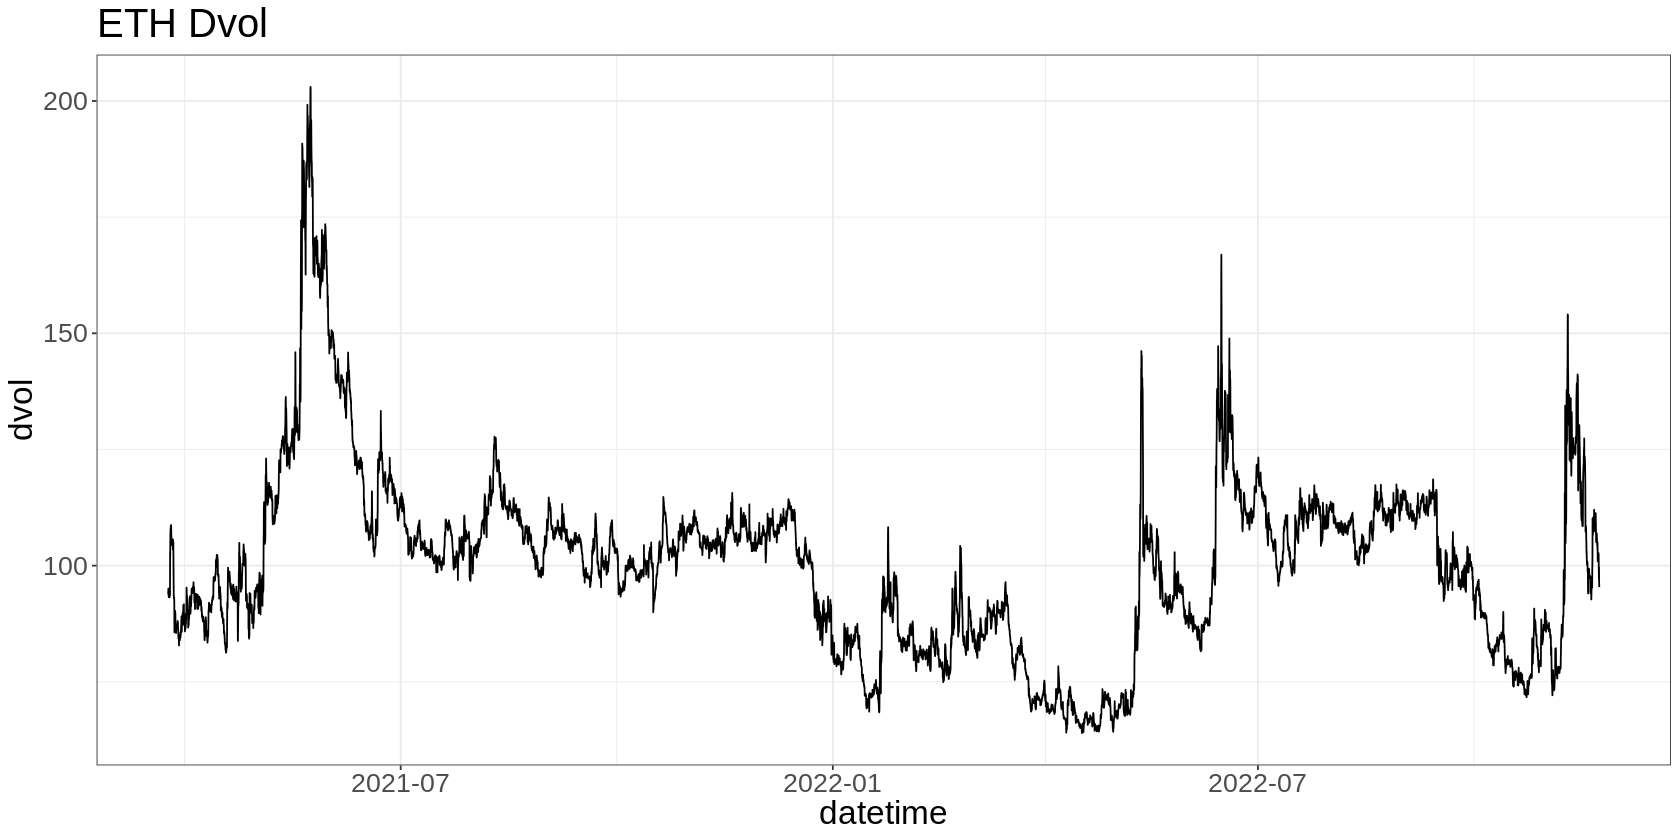

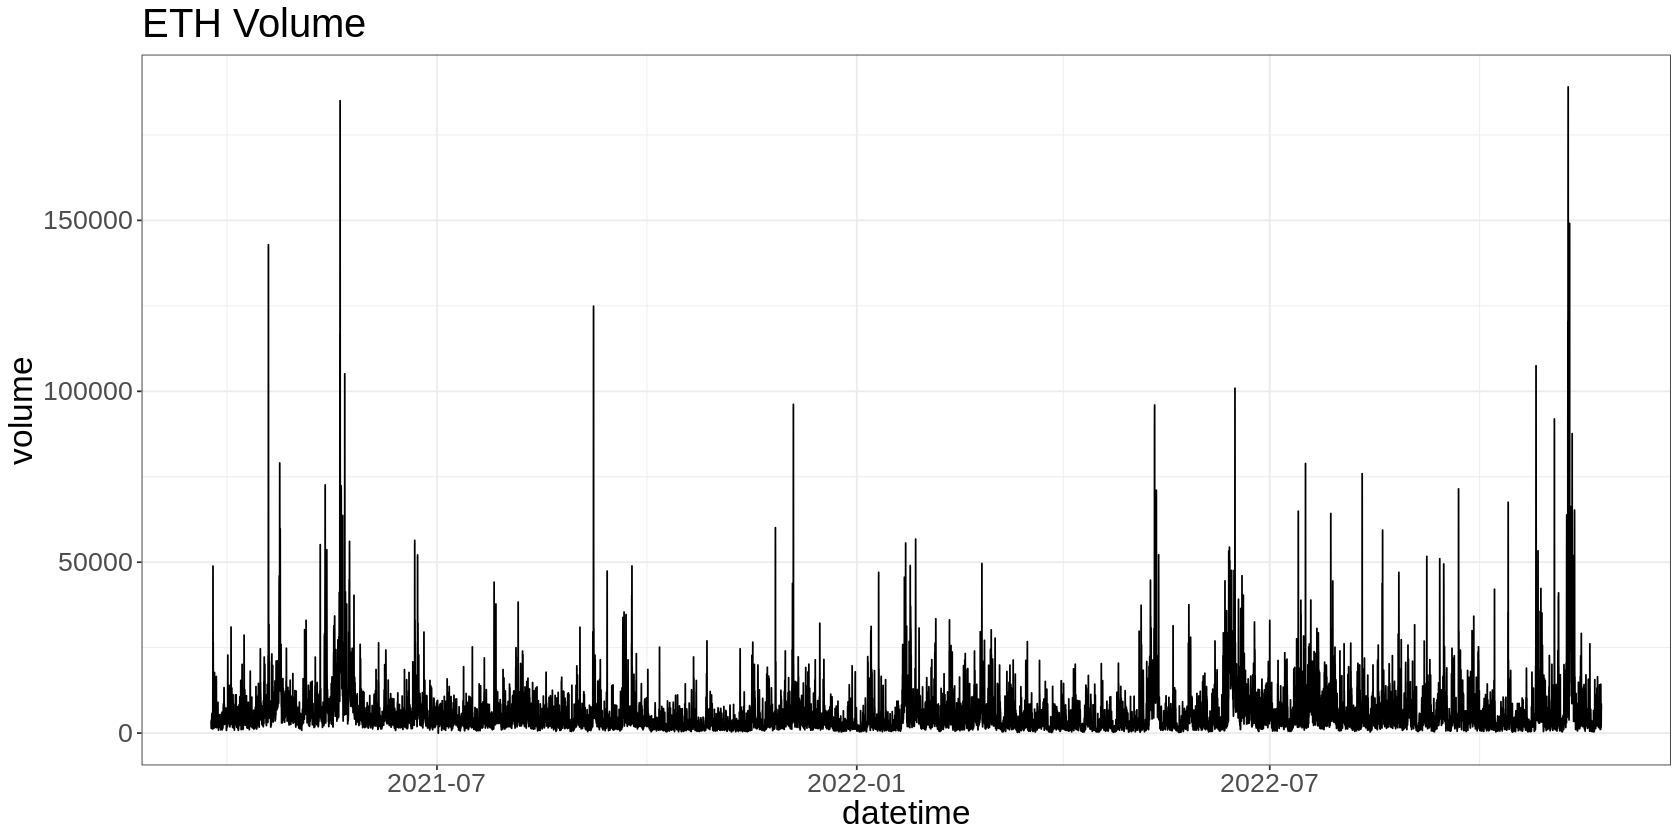

In [ ]:
eth_combined %>% 
    ggplot(aes(x=datetime, y=close)) +
      geom_line() +
      ggtitle('ETH Close')
  
eth_combined %>% 
    ggplot(aes(x=datetime, y=dvol)) +
      geom_line() +
      ggtitle('ETH Dvol')
    
eth_combined %>% 
    ggplot(aes(x=datetime, y=volume)) +
      geom_line() +
      ggtitle('ETH Volume')

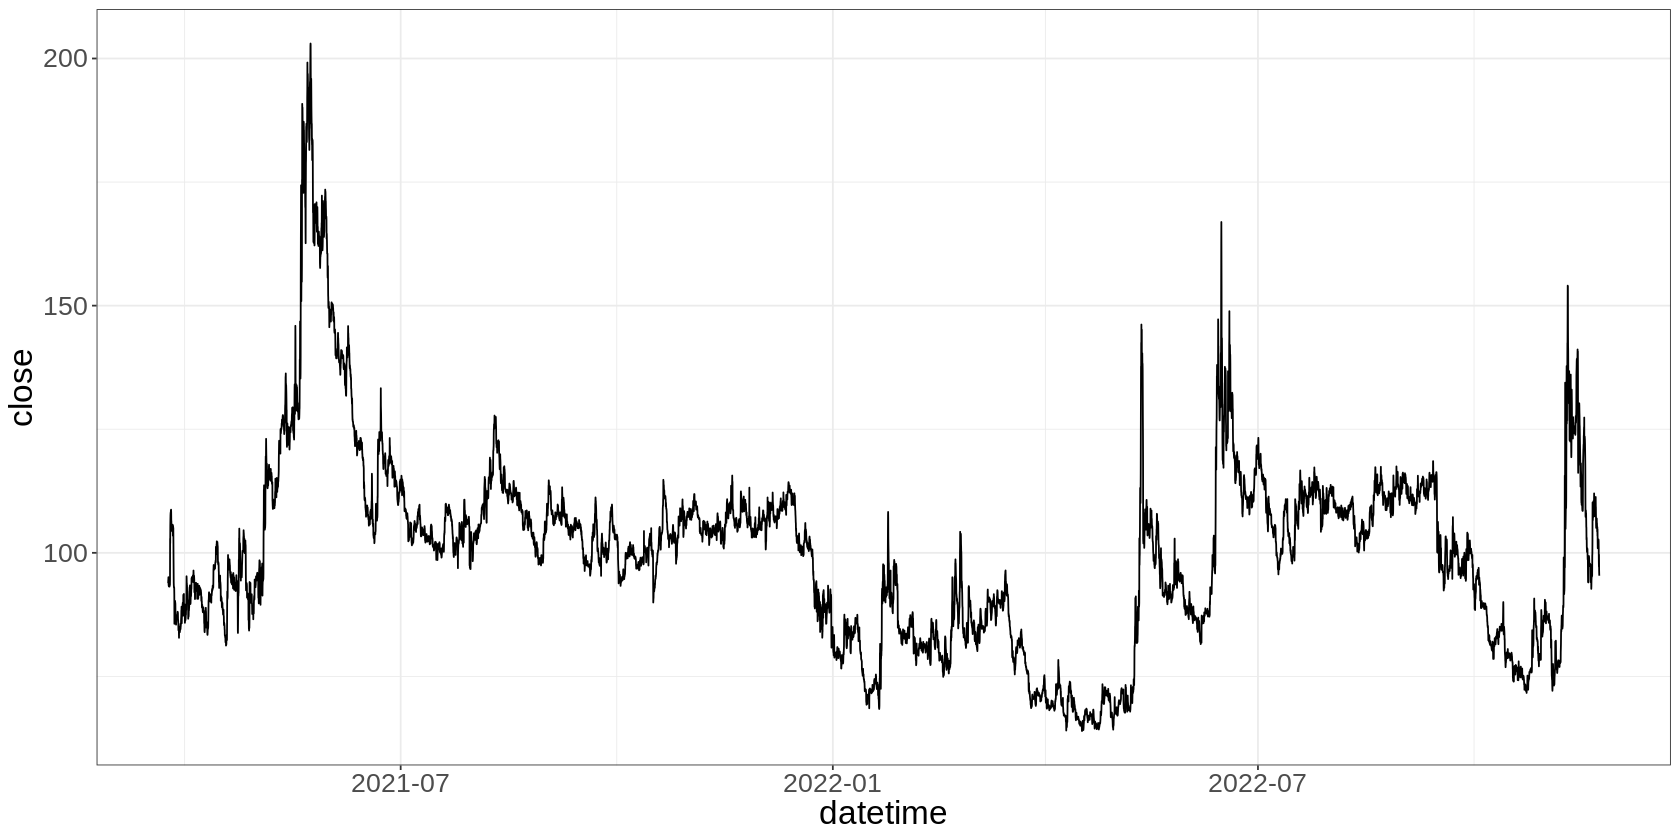

In [ ]:
eth_vol %>%
  ggplot(aes(x=datetime, y=close)) +
    geom_line()

# Returns as Volatility Factor

A delta hedged long vega position lose money when underlying pumps as vol drops. Then makes money as vol spike from dumps. Surely that wouldn't be the case if upside and download volatility is treated the same way.

In [ ]:
eth_returnfactor <- eth_combined %>% 
  mutate(
    c2c_simplevol = dvol / lag(dvol) - 1,
    c2c_logvol = log(dvol/lag(dvol)),
    c2c_logreturn = log(close/lag(close)),
    fwd_vol = log(lead(dvol, n = 2)/lead(dvol, n = 1)),
    return_sign = case_when(c2c_logreturn < 0 ~ "-1", TRUE ~ "1")
  ) %>%
  arrange(datetime) %>%
  na.omit()

Now it's time to plot. That's a swarm of bees but one with regression line.

`geom_smooth()` using formula = 'y ~ x'


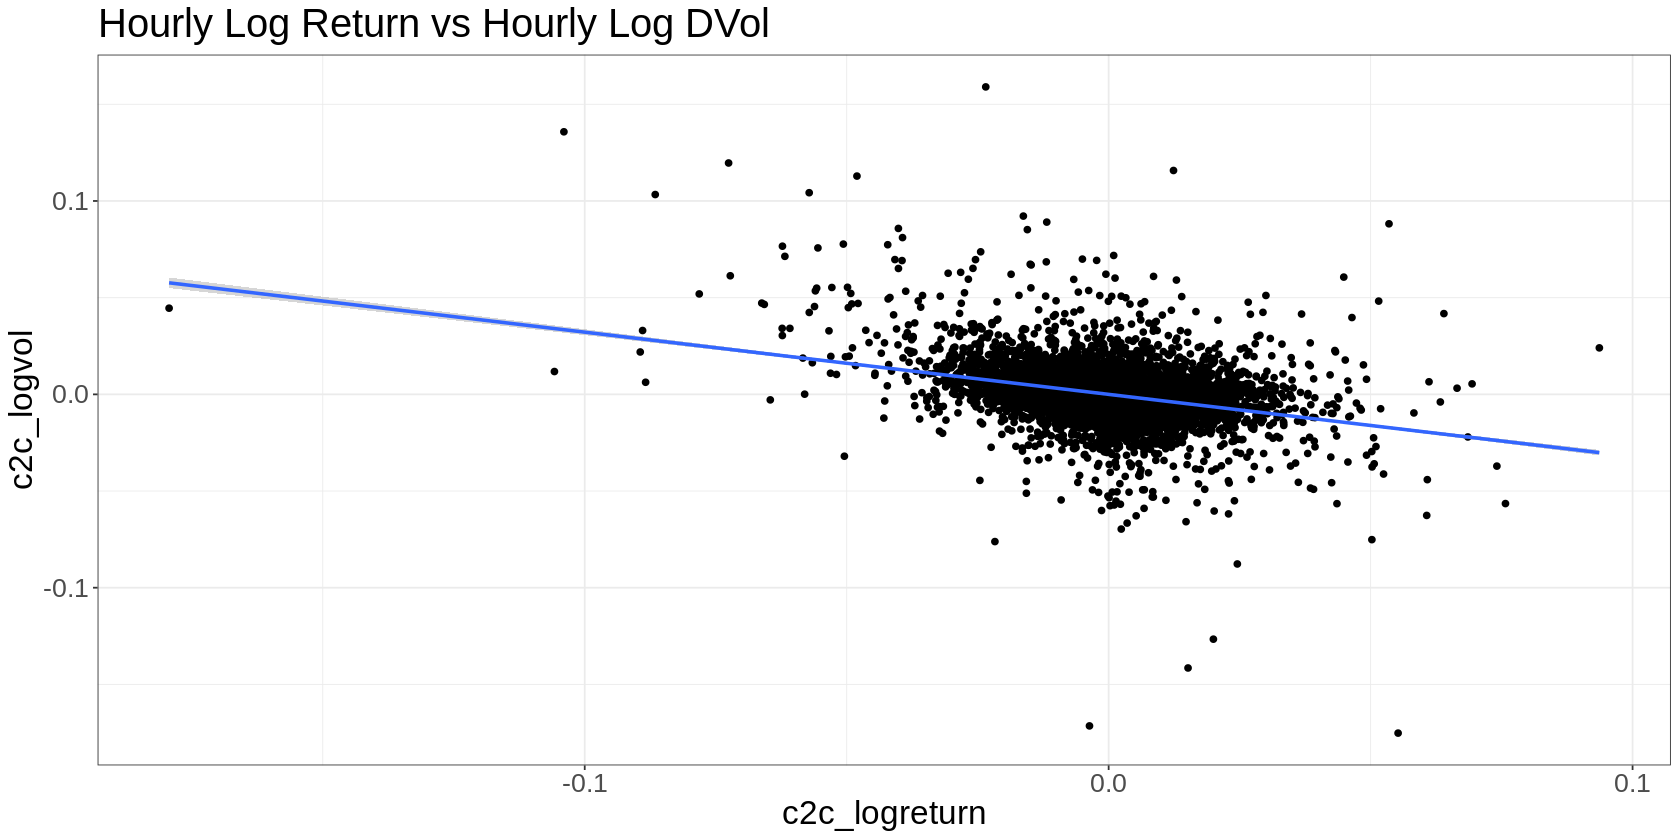

In [ ]:
eth_returnfactor %>%
  ggplot(aes(x=c2c_logreturn, y=c2c_logvol)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Hourly Log Return vs Hourly Log DVol')

Reality check: Doesn't work every month of course even our small sample size. But still carries the same shape to the latest month.

`geom_smooth()` using formula = 'y ~ x'


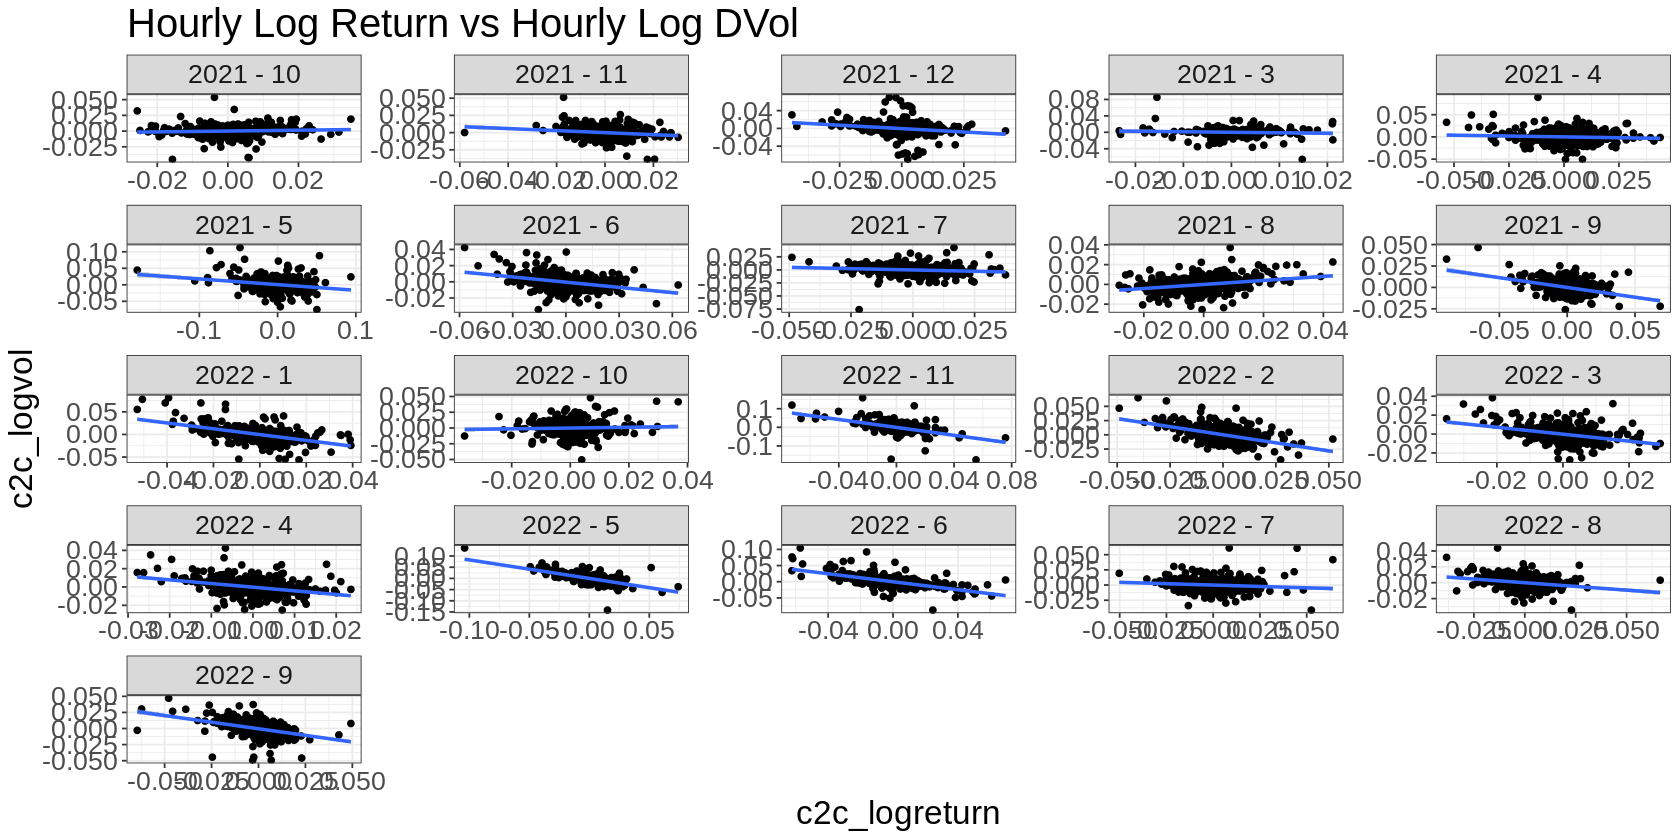

In [ ]:
eth_returnfactor %>%  
    mutate(
      year = lubridate::year(datetime),
      month = lubridate::month(datetime),
      yearmonth = paste(year,'-', month),
    ) %>%
    ggplot(aes(x=c2c_logreturn, y=c2c_logvol)) + 
      geom_point() + 
      geom_smooth(method='lm') + 
      ggtitle('Hourly Log Return vs Hourly Log DVol') +
      facet_wrap(~yearmonth, scales='free')

Yeah but is that effect small or large? What if we group by day. On the small side, but still the same direction tilt. This means act faster.

`geom_smooth()` using formula = 'y ~ x'


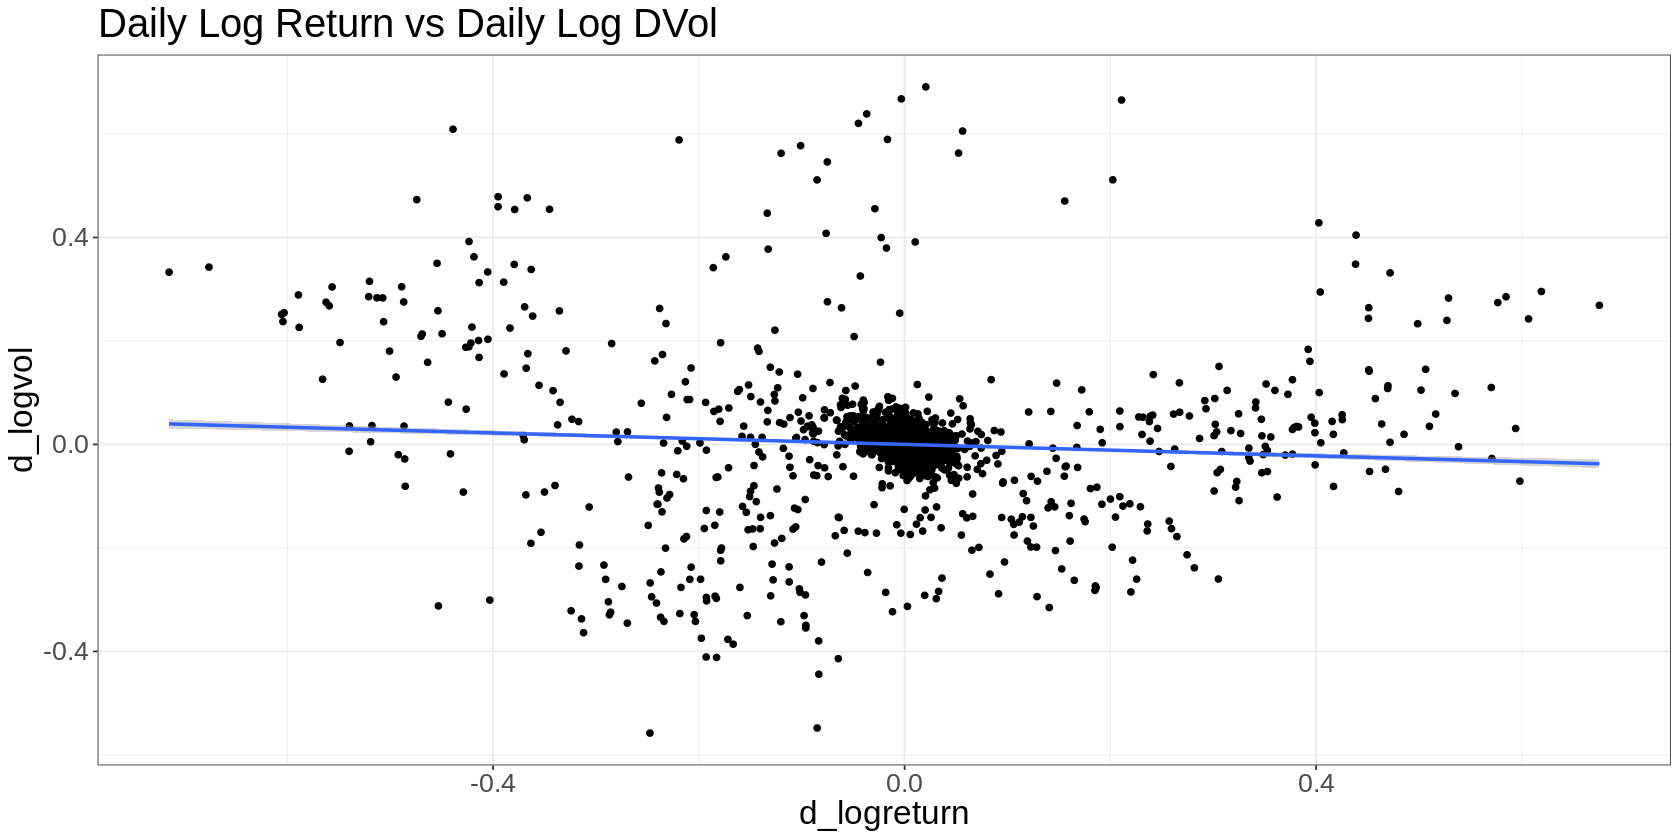

In [ ]:
eth_returnfactor %>%
  mutate(day = lubridate::day(datetime)) %>%
  group_by(day) %>%
  mutate(
    d_logvol = log(dvol/lag(dvol)),
    d_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  ggplot(aes(x=d_logreturn, y=d_logvol)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Daily Log Return vs Daily Log DVol')

So we know the relationship between past return and past vol. But that's not really useful since we can only act on information in the future. 

The first chart shows us again that there's not really statistical significant relationship of hourly return to the next. Vol though is still autocorrelated even 2 hours later, that's an eternity in cryptoland.

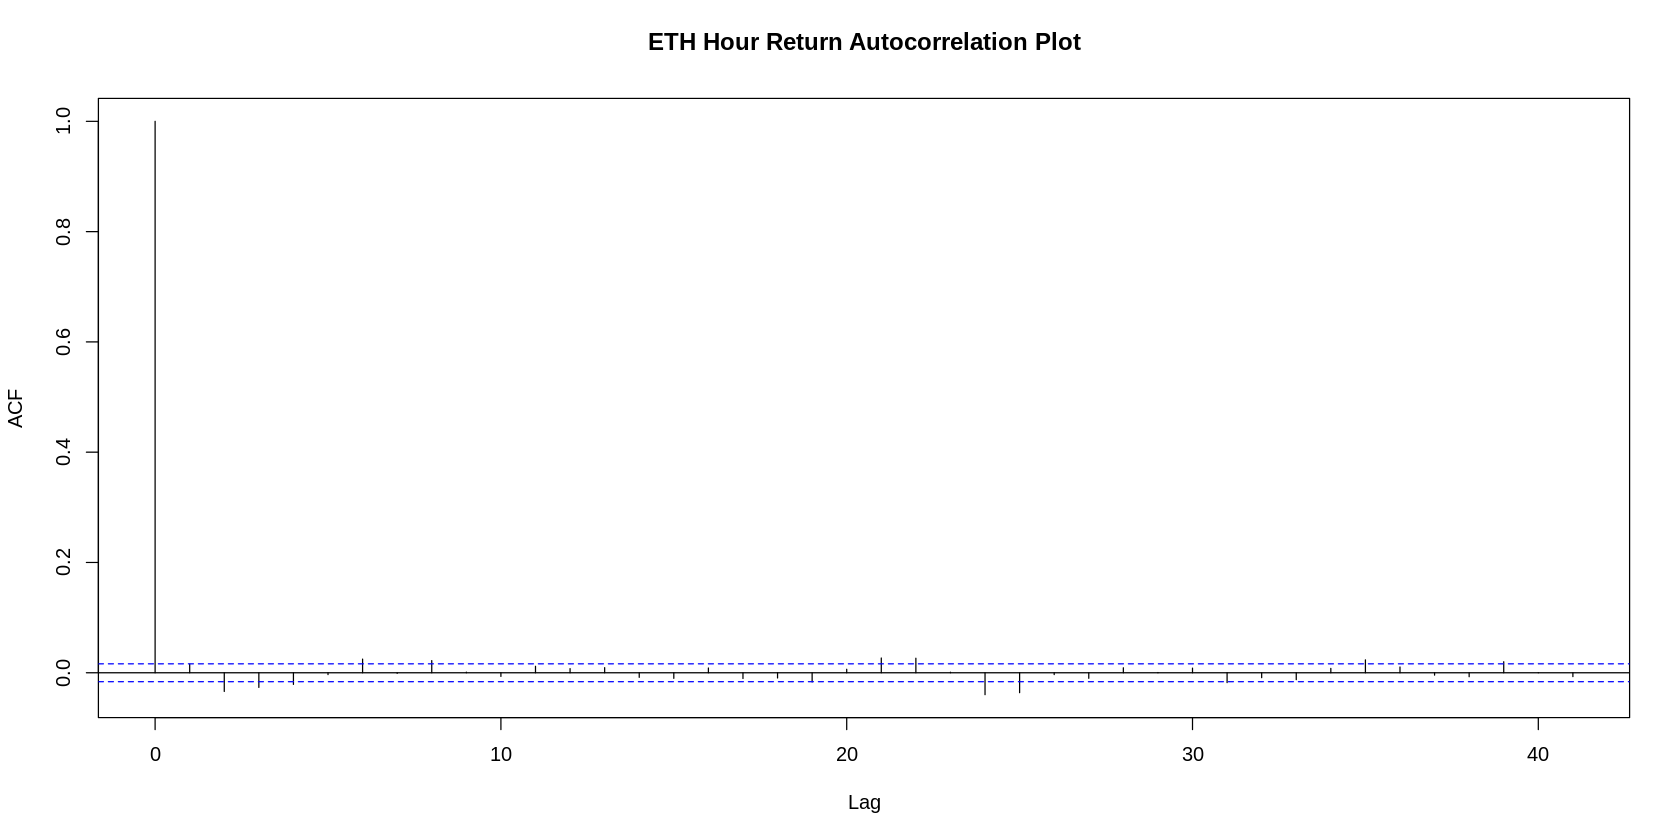

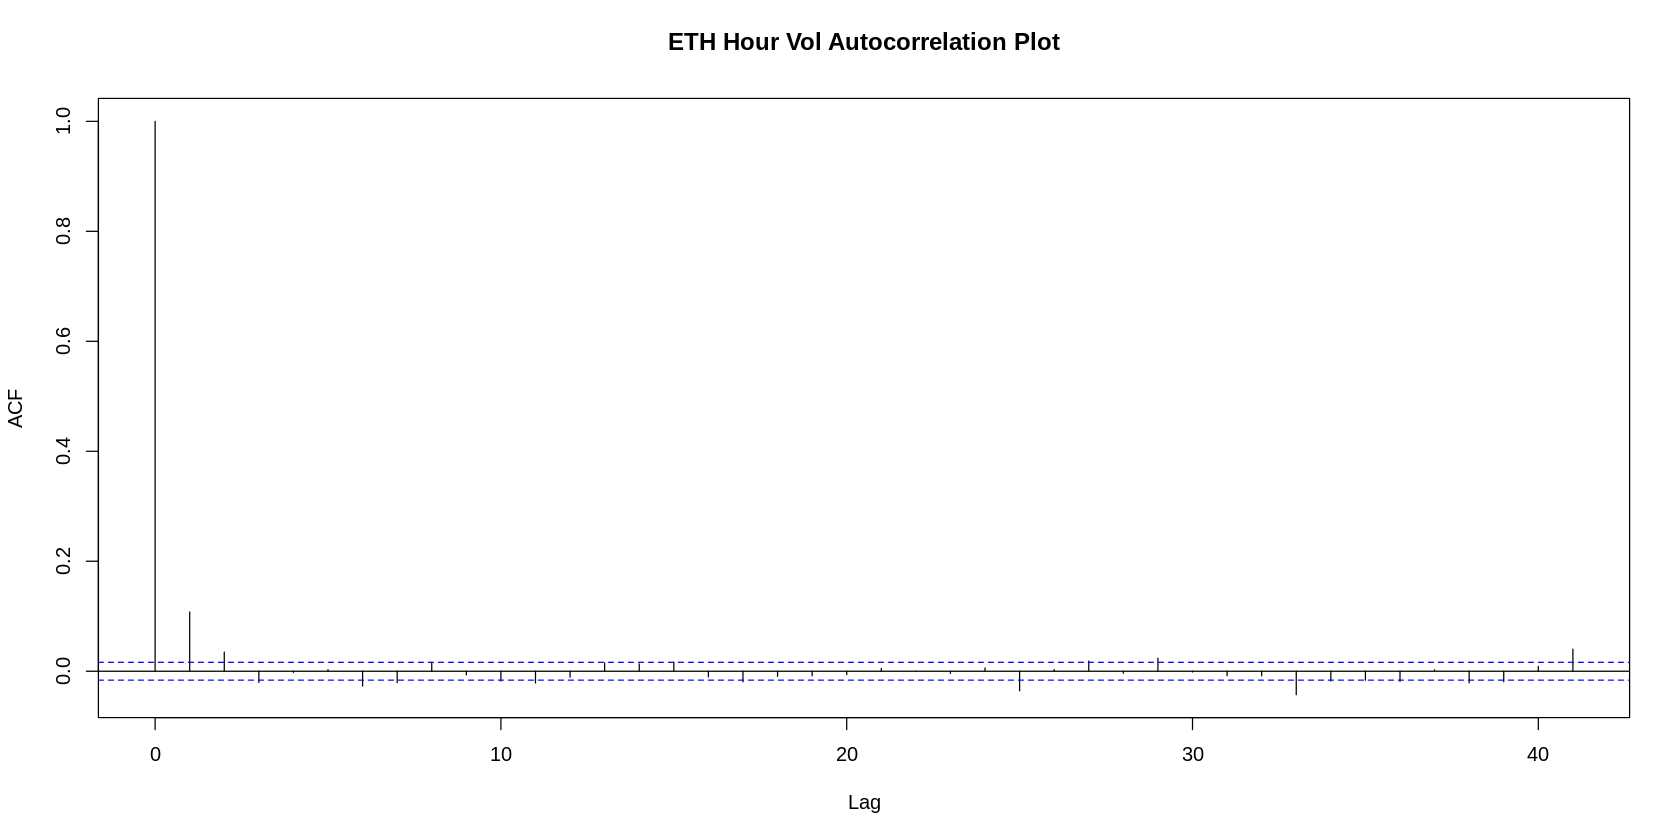

In [ ]:
plot(acf(eth_returnfactor$c2c_logreturn,plot=FALSE),main="ETH Hour Return Autocorrelation Plot")

plot(acf(eth_returnfactor$c2c_logvol,plot=FALSE),main="ETH Hour Vol Autocorrelation Plot")

Next we check the next hour log vol based on log return showing the same shape, it does and it's weaker as expected.

`geom_smooth()` using formula = 'y ~ x'


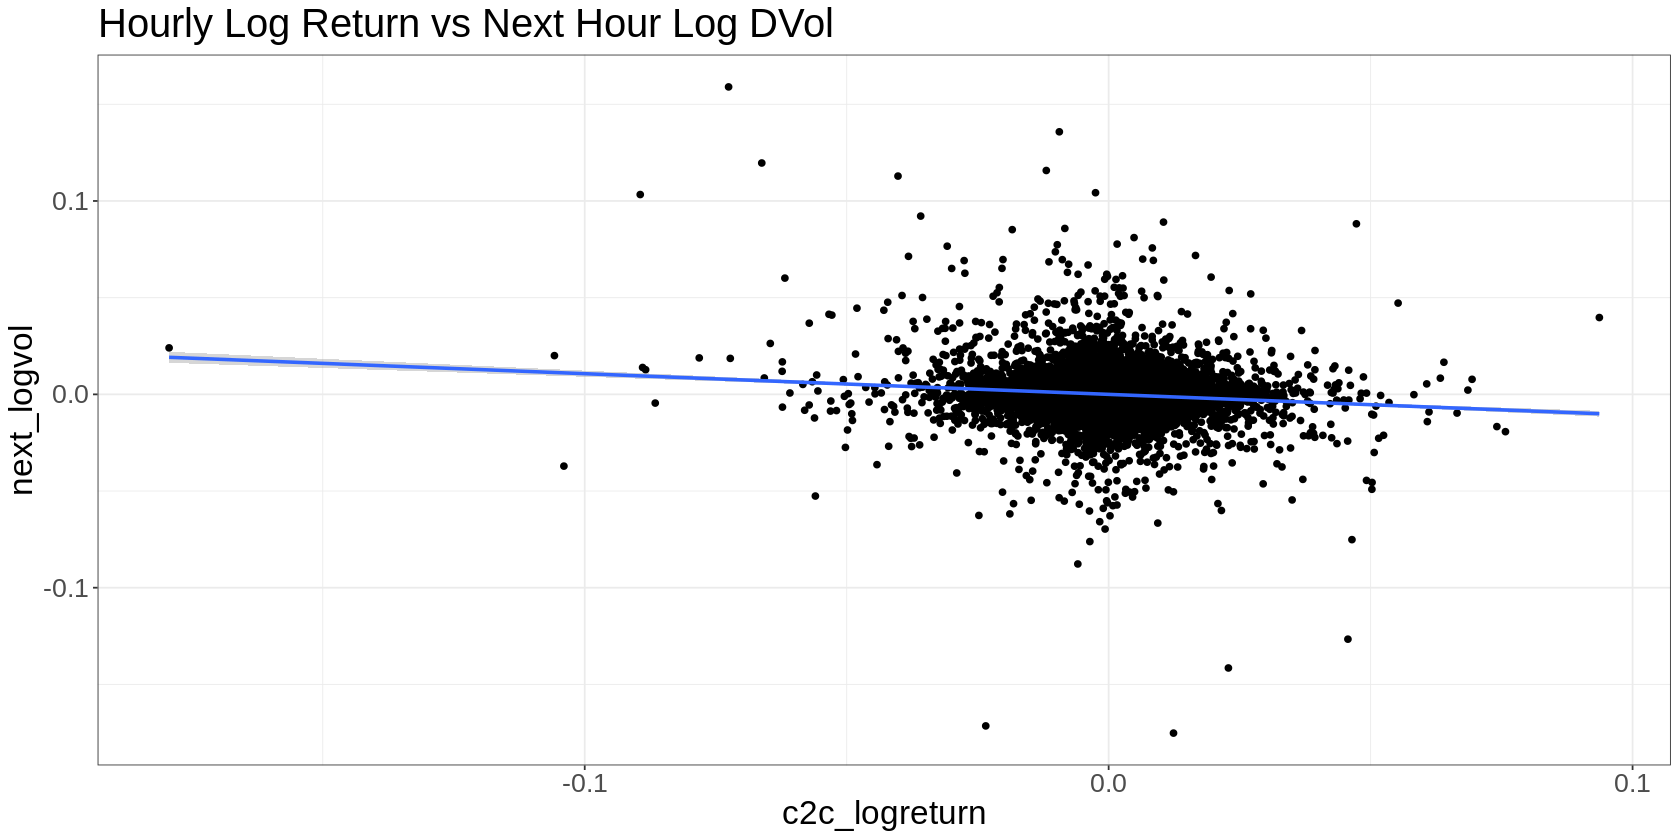

In [ ]:
eth_returnfactor %>%
  arrange(datetime) %>%
  mutate(next_logvol = lead(c2c_logvol, 1)) %>%
  na.omit() %>%
  ggplot(aes(x=c2c_logreturn, y=next_logvol)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Hourly Log Return vs Next Hour Log DVol')

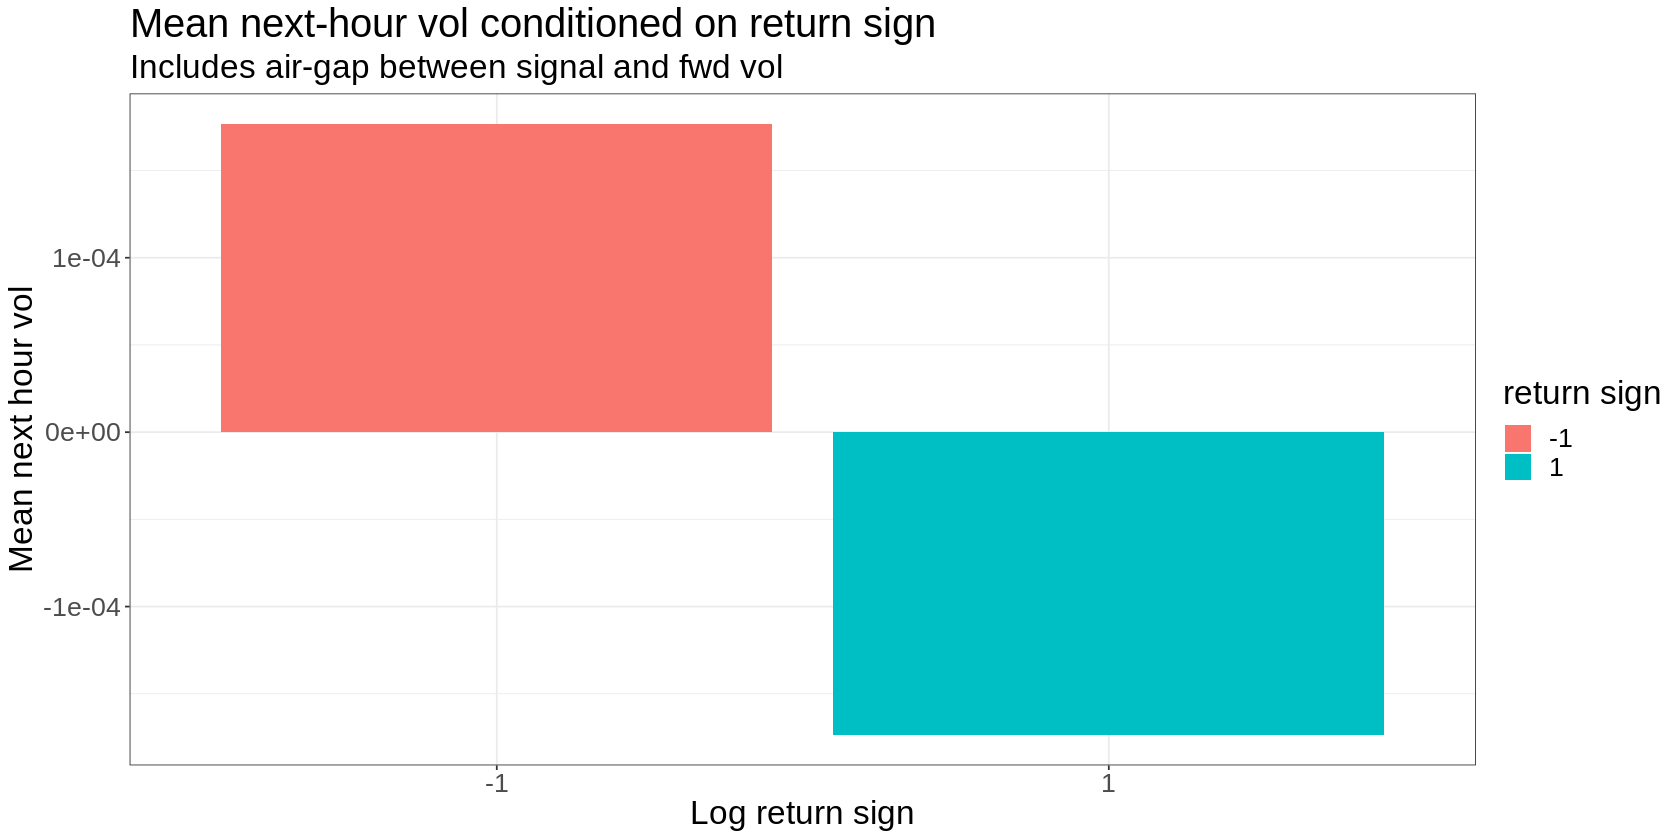

In [ ]:
eth_returnfactor %>%
  group_by(return_sign) %>%
  summarise(mean_fwd_vol = mean(fwd_vol, na.rm = TRUE)) %>%
  ggplot(aes(y = mean_fwd_vol, x = return_sign, fill = return_sign)) +
    geom_bar(stat = 'identity') +
    labs(
      x = "Log return sign",
      y = "Mean next hour vol",
      title = "Mean next-hour vol conditioned on return sign",
      subtitle = "Includes air-gap between signal and fwd vol",
      fill = "return sign"
    )

## Dumb Costless Ape Vol Strategies on Return Sign

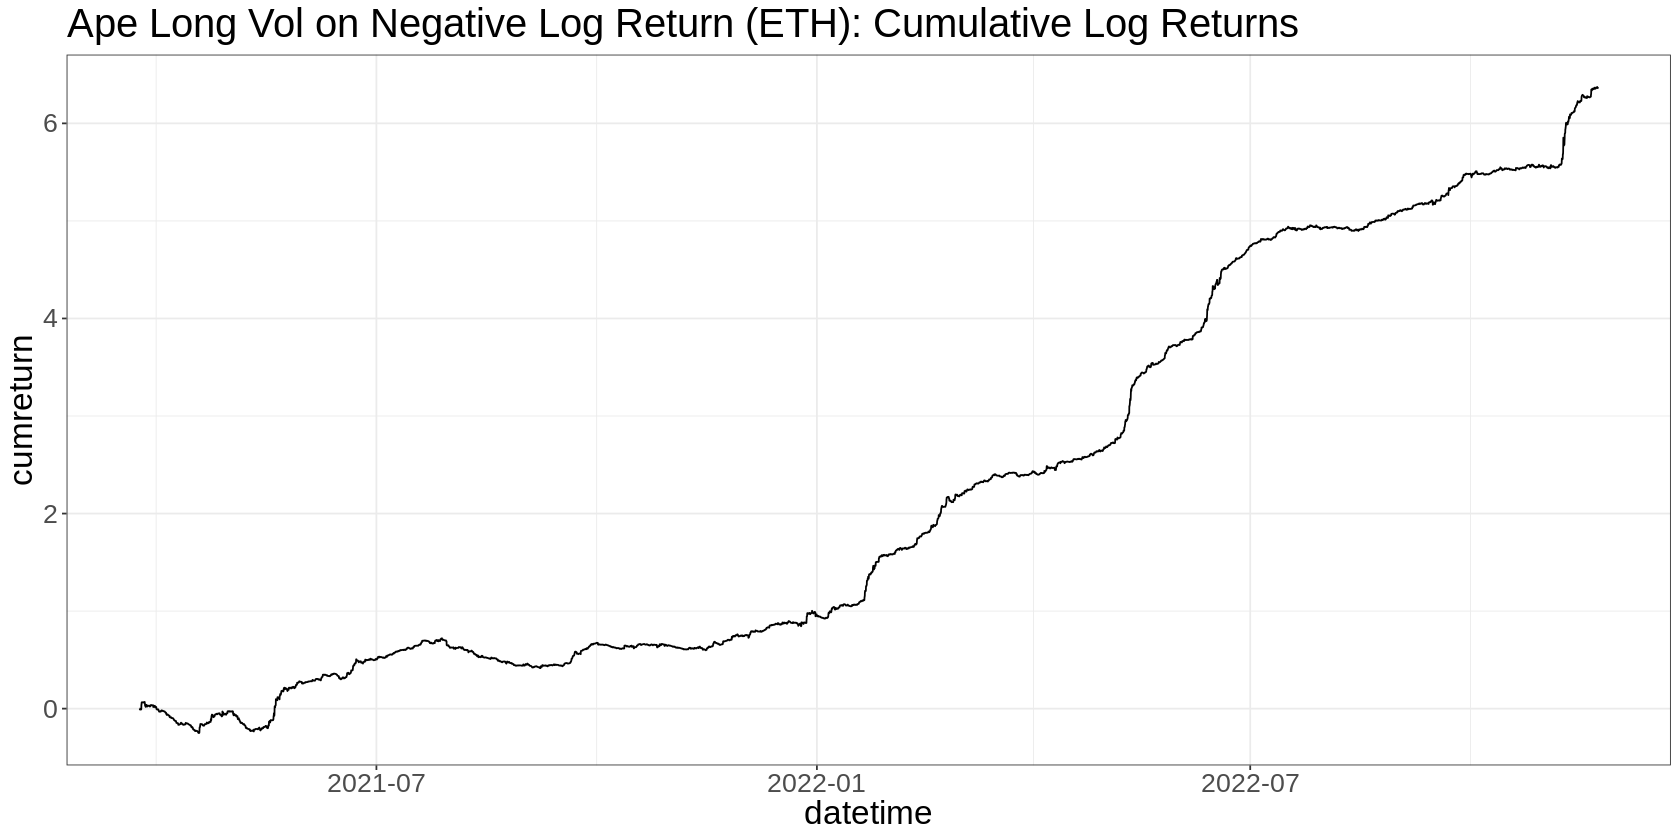

In [ ]:
eth_returnfactor %>%
  mutate(strat_return = case_when(return_sign < 0 ~ c2c_simplevol, TRUE ~ 0)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('Ape Long Vol on Negative Log Return (ETH): Cumulative Log Returns')

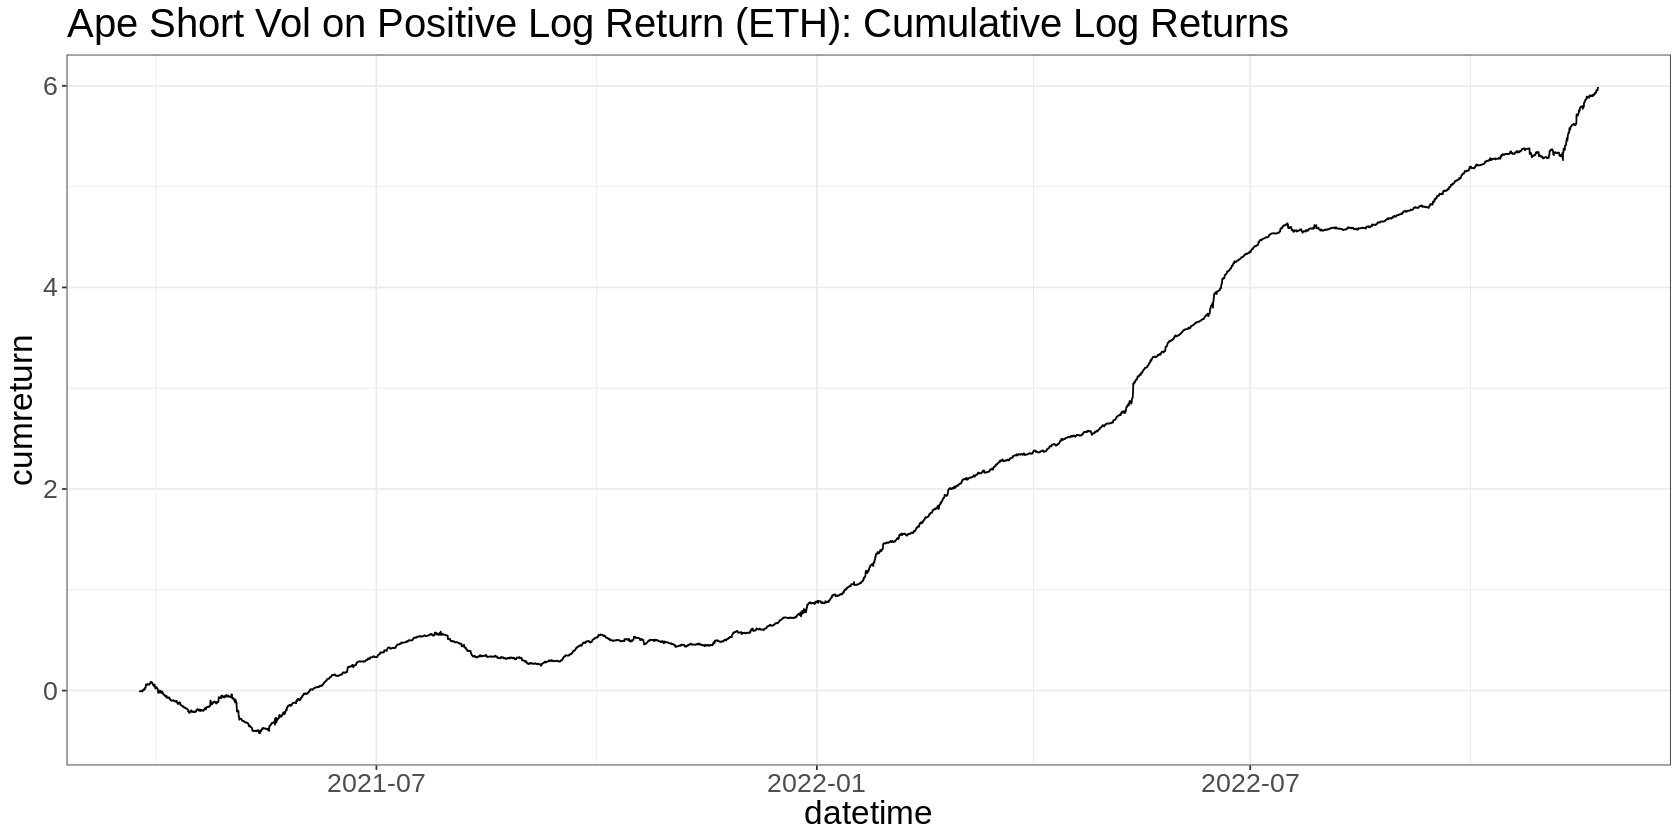

In [ ]:
eth_returnfactor %>%
  mutate(strat_return = case_when(return_sign > 0 ~ -c2c_simplevol, TRUE ~ 0)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('Ape Short Vol on Positive Log Return (ETH): Cumulative Log Returns')

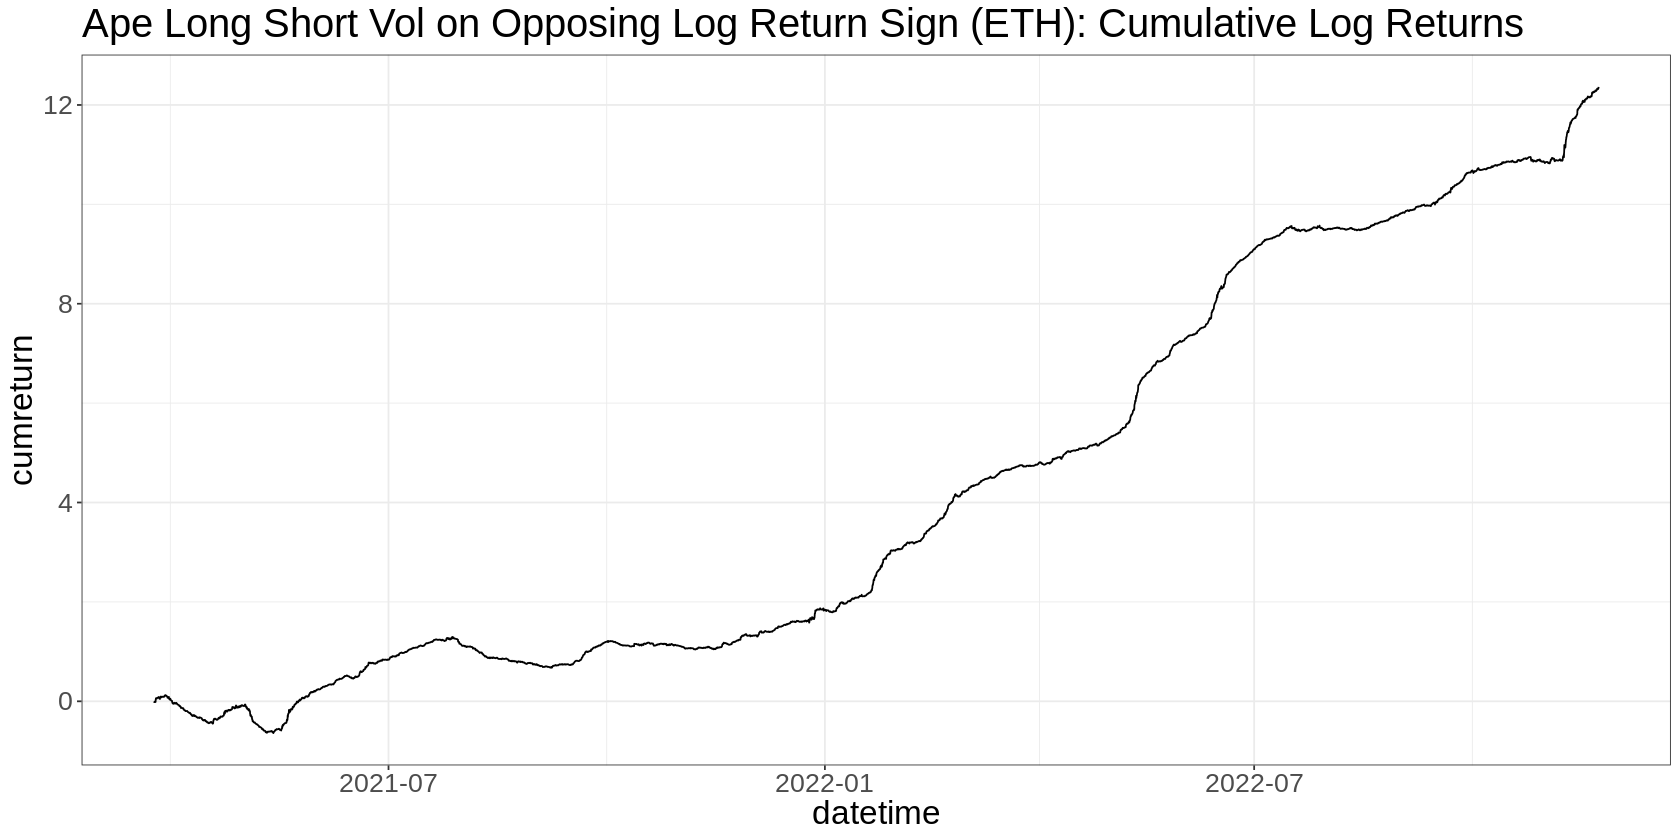

In [ ]:
eth_returnfactor %>%
  mutate(strat_return = case_when(return_sign < 0 ~ c2c_simplevol, TRUE ~ -c2c_simplevol)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('Ape Long Short Vol on Opposing Log Return Sign (ETH): Cumulative Log Returns')

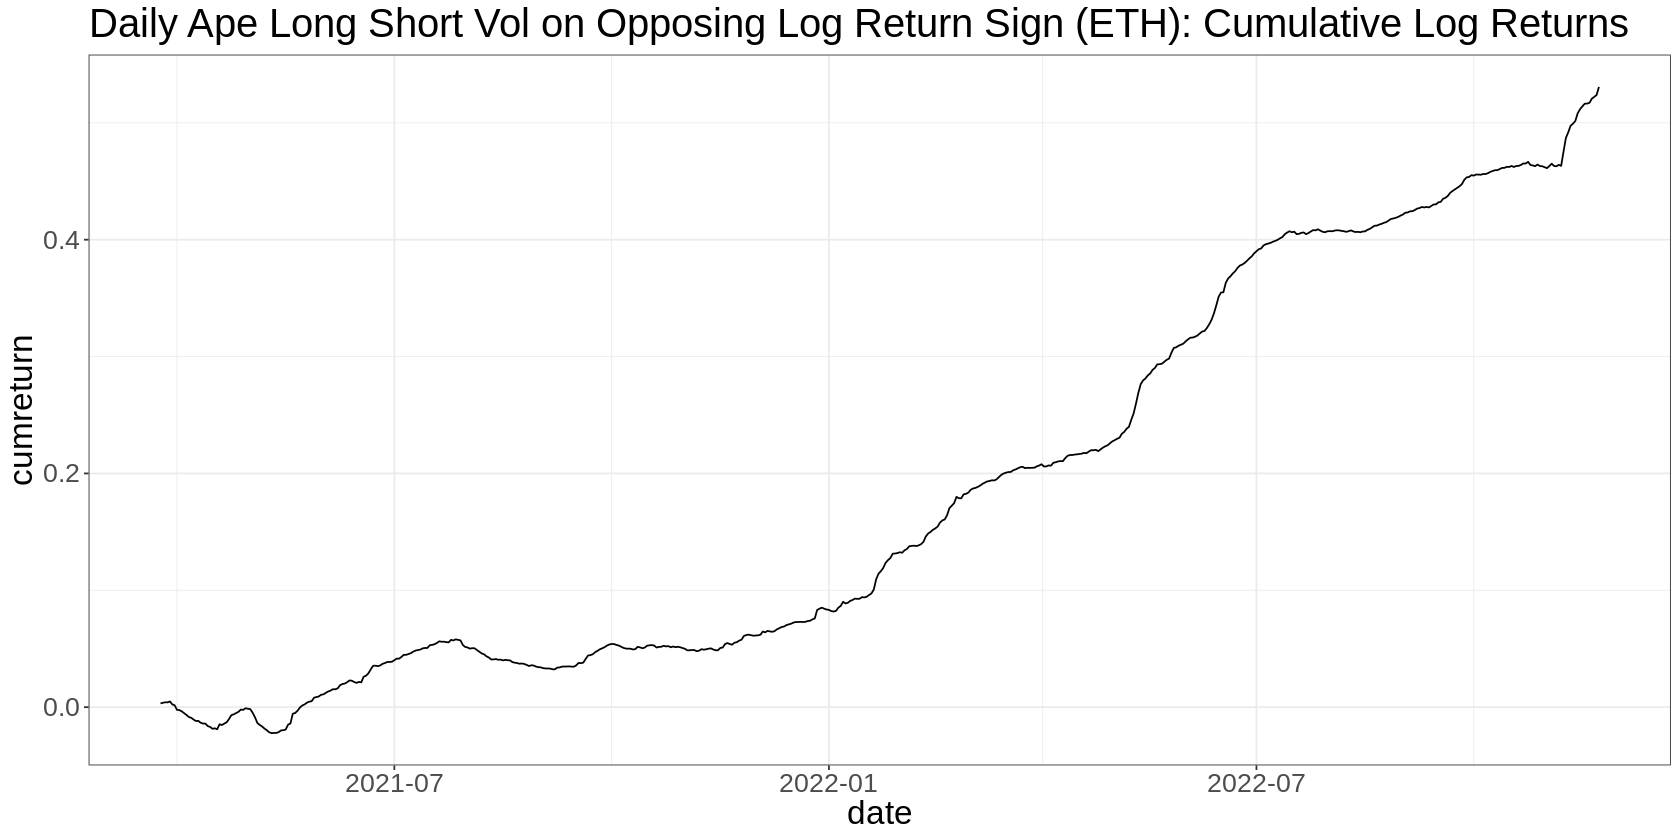

In [ ]:
eth_returnfactor %>%
  mutate(date = lubridate::date(datetime)) %>%
  group_by(date) %>%
  mutate(
    d_simplevol = dvol / lag(dvol) - 1,
    d_logreturn = log(close/lag(close)),
    d_return_sign = case_when(d_logreturn < 0 ~ "-1", TRUE ~ "1"),
    strat_return = case_when(d_return_sign < 0 ~ d_simplevol, TRUE ~ -d_simplevol)
  ) %>%
  na.omit() %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('Daily Ape Long Short Vol on Opposing Log Return Sign (ETH): Cumulative Log Returns')

Based on my copypasta of R so far, and I might have done too many things wrong to get these plots but really it looks like return is a stronger effect than seasonality as a factor of implied volatility.

## Volume as Volatility Factor

The hunch from hourly seasonality research was that it's not actually the hour of the day that drives or lowers Dvol but actually a volume effect. Since the lowest volume hour UTC 15 was also noticeable in the hourly seasonality hour. Let's fun around and find out.

In [ ]:
eth_returnfactor <- eth_returnfactor %>%
  arrange(datetime) %>%
  filter_if(is.numeric, all_vars((.) != 0)) %>% 
  mutate(
    c2c_logvolume = log(volume/lag(volume)),
    volume_sign = case_when(c2c_logreturn < 0 ~ "-1", TRUE ~ "1")
  ) %>%
  na.omit()

Well that seems to be a smaller effect than return so far. Though notably it barely change when plotted in the daily timescale. So could be that it's a slow moving factor. It doesn't show anything notable when plotted against forward vol.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


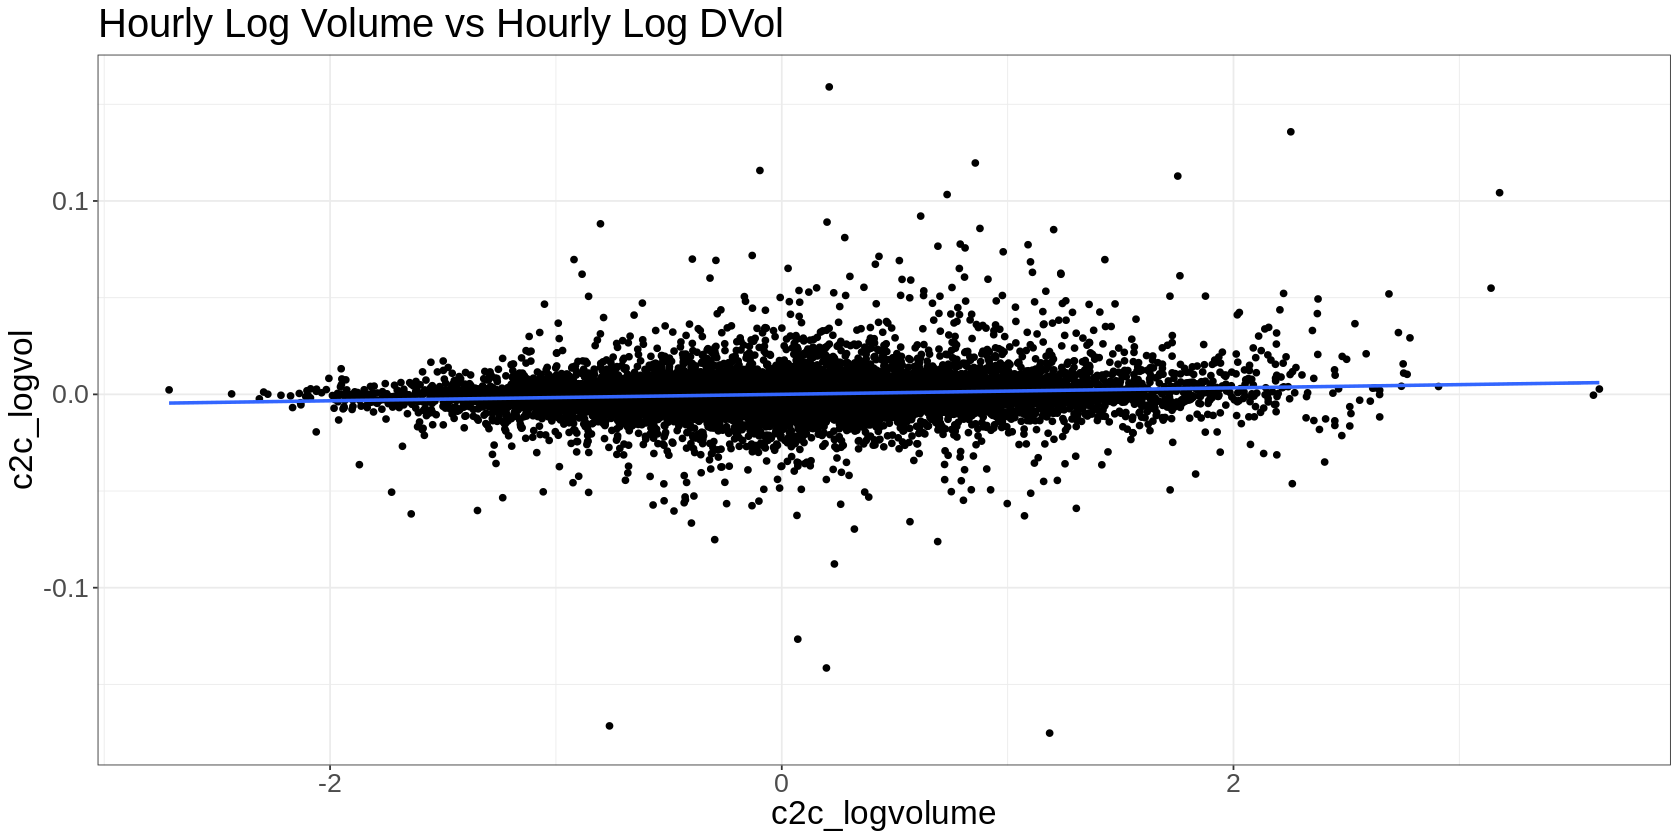

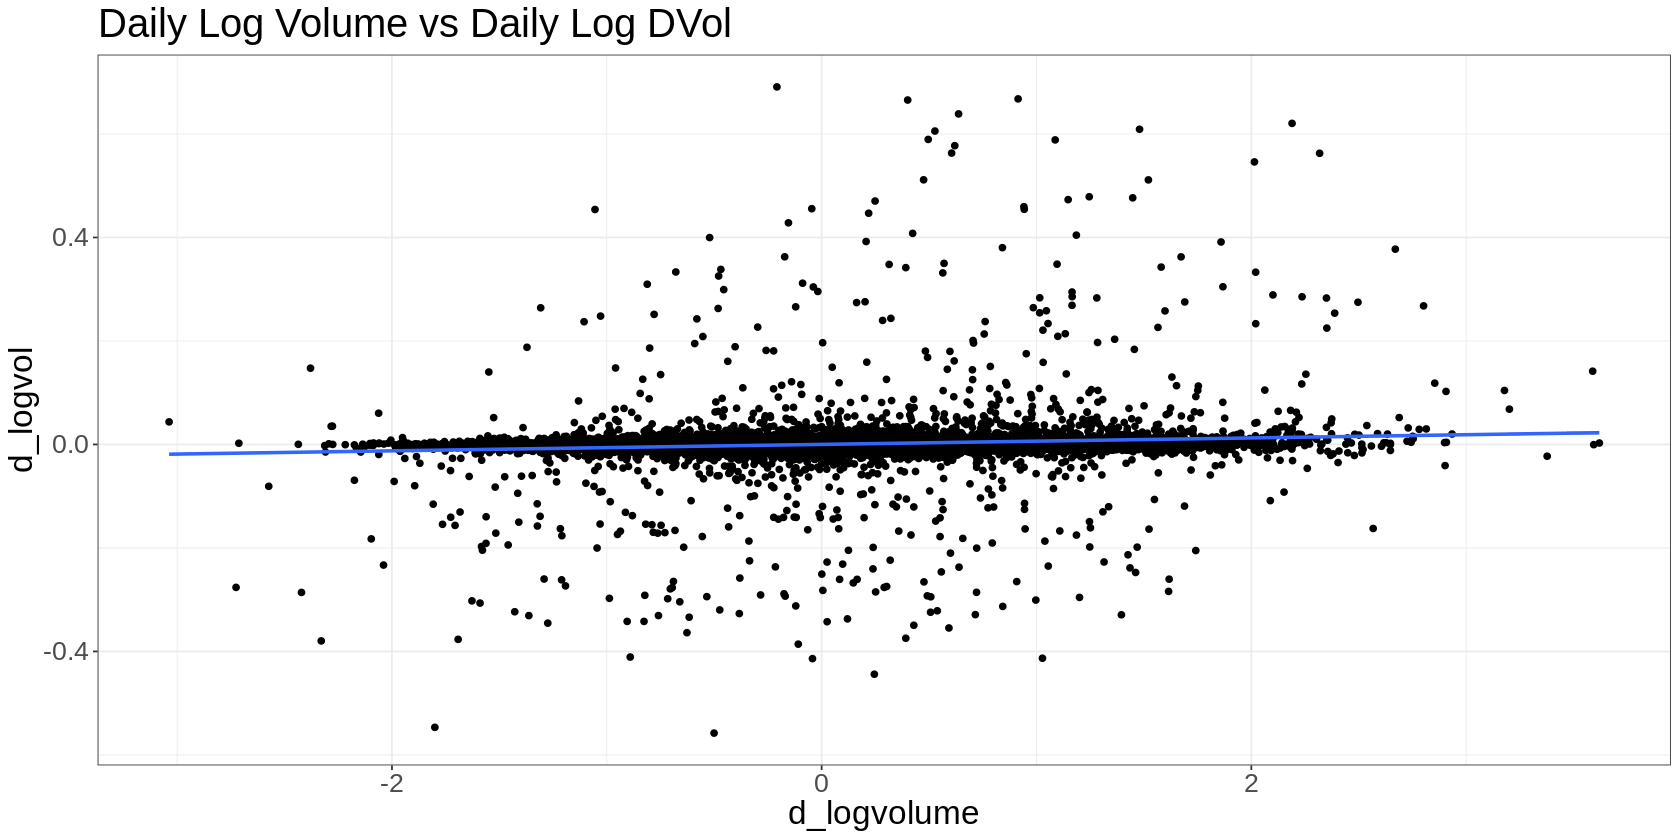

In [ ]:
eth_returnfactor %>%
  ggplot(aes(x=c2c_logvolume, y=c2c_logvol)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Hourly Log Volume vs Hourly Log DVol')

eth_returnfactor %>%
  mutate(day = lubridate::day(datetime)) %>%
  group_by(day) %>%
  mutate(
    d_logvol = log(dvol/lag(dvol)),
    d_logvolume = log(volume/lag(volume)),
  ) %>%
  na.omit() %>%
  ggplot(aes(x=d_logvolume, y=d_logvol)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Daily Log Volume vs Daily Log DVol')

In [ ]:
eth_returnfactor %>%
  arrange(datetime) %>%
  mutate(next_logvol = lead(c2c_logvol, 1)) %>%
  na.omit() %>%
  ggplot(aes(x=c2c_logvolume, y=next_logvol)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Hourly Log Vol vs Next Hour Log DVol')

I haven't done a volume plot before. Unexpectedly volume has a negative autocorrelation with itself. For a few hours too. This says that hourly volume comes in spurts. So when there's volume to enter and exit positions do take that opportunity.

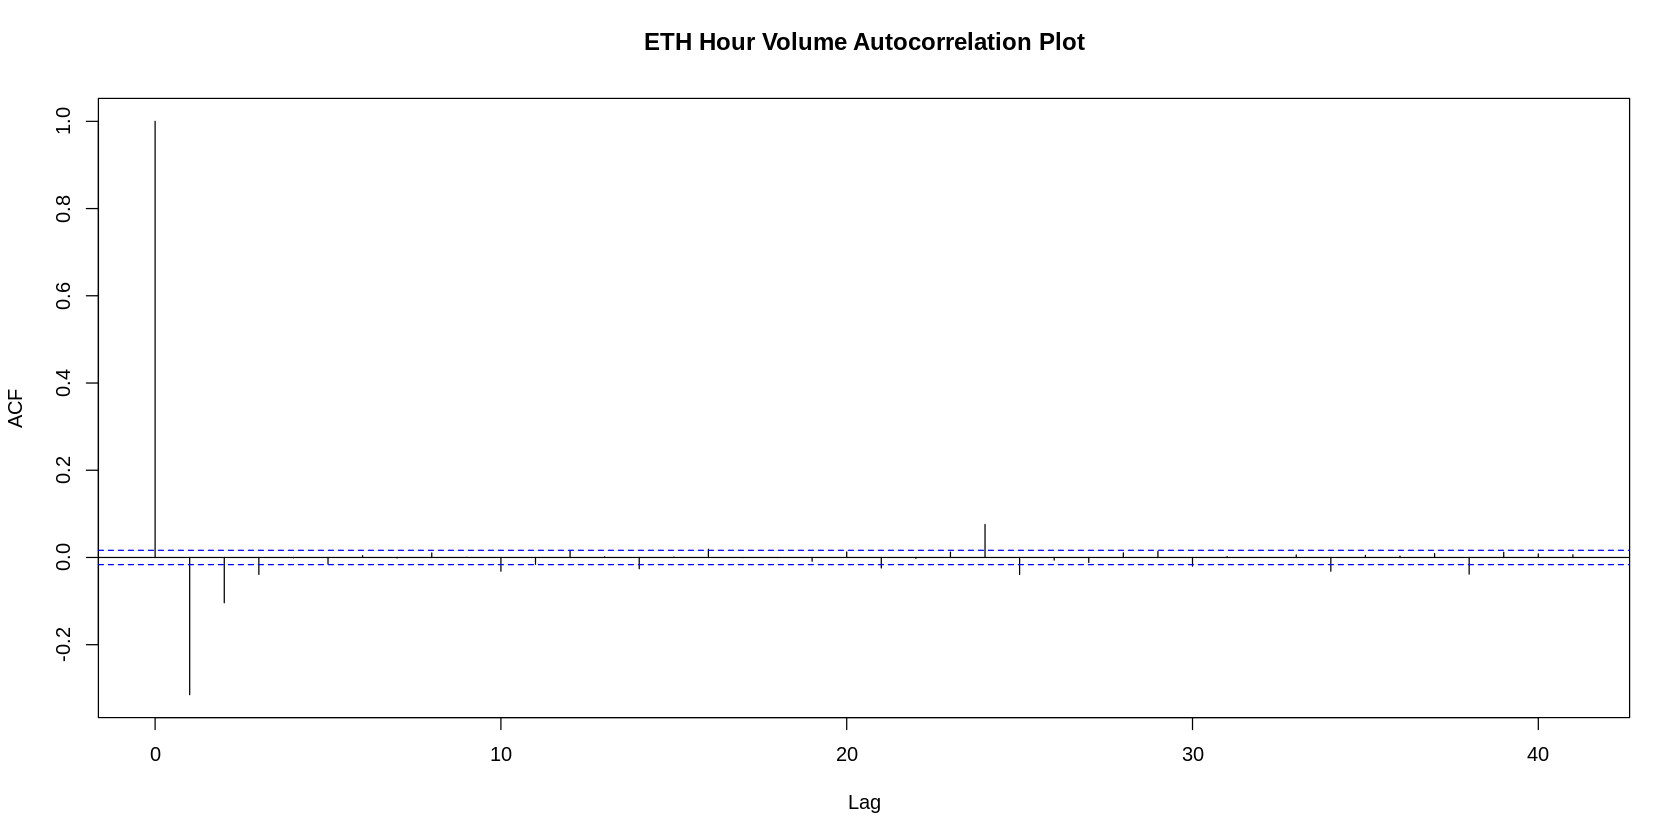

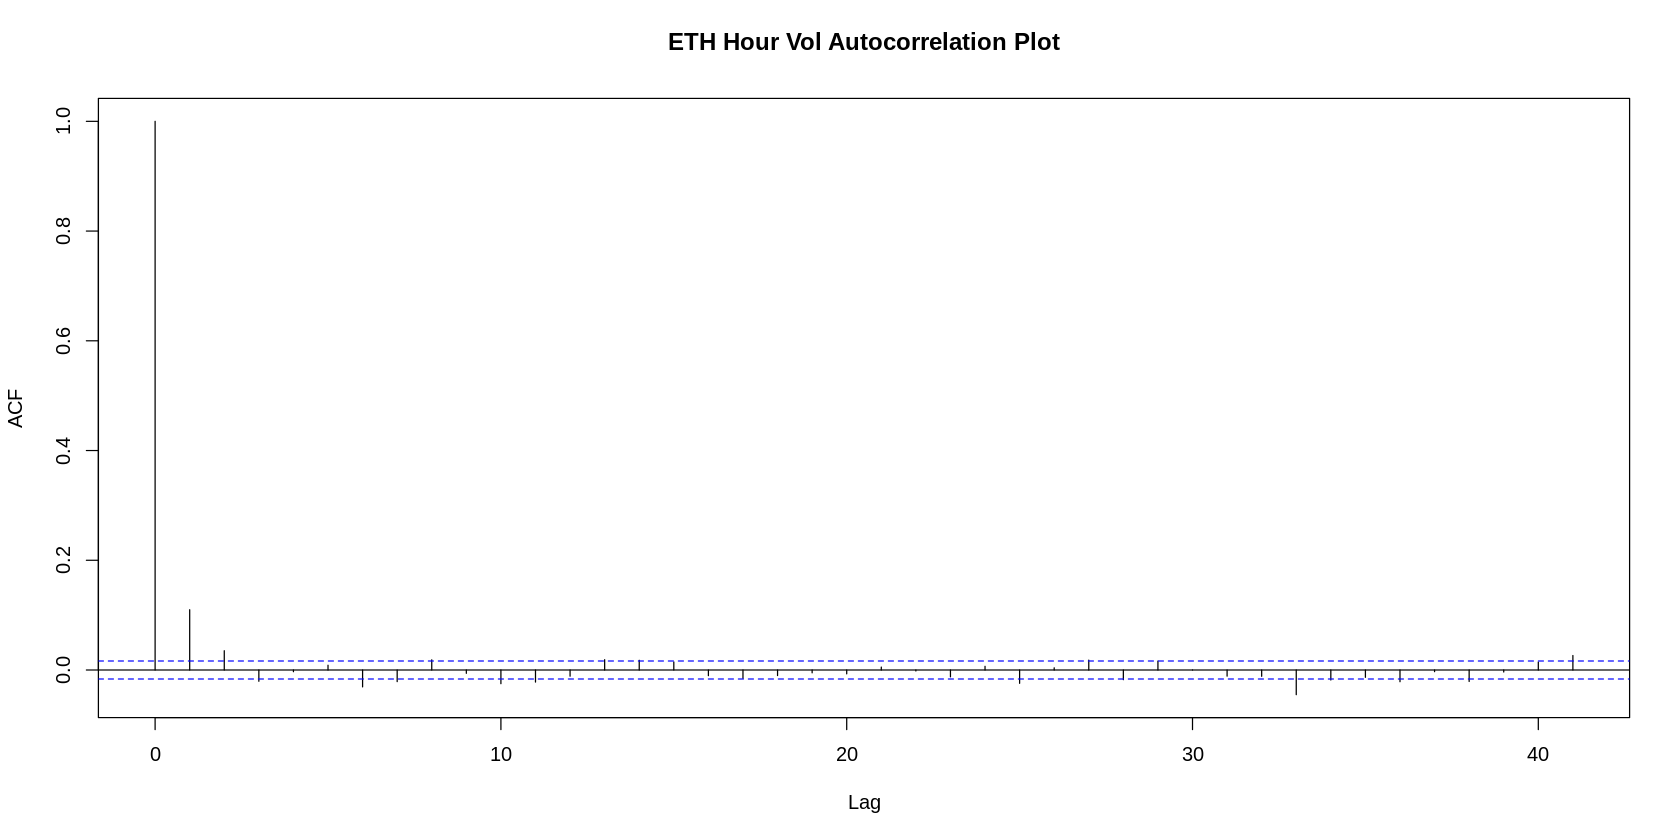

In [ ]:
plot(acf(eth_returnfactor$c2c_logvolume,plot=FALSE),main="ETH Hour Volume Autocorrelation Plot")

plot(acf(eth_returnfactor$c2c_logvol,plot=FALSE),main="ETH Hour Vol Autocorrelation Plot")

# What's Next

I been procrastinating reading [SPX-Options-Trading:
The Kir Strategy](http://www.godotfinance.com/pdf/SPXOptionsStrategy_Rev2.pdf) as mentioned in the TLAQ VRP material. I'm sourcing 1M ATM IV and 3M ATM IV for Crypto Options, having that I'd be able to replicate the methods in this [2022 Review and Alternative Implementations](https://colab.research.google.com/drive/1X8crftLPQVpASmSxJFnCCm2Te_K6d2qS?usp=sharing#scrollTo=LL8NRzPo_871) notebook from TLAQ VRP.